# Applying Data Science Model Development (LSTM)

## 1. Preprocess the data

In [2]:
pip install optuna

   ---------------------------------------- 0.0/383.6 kB ? eta -:--:--
   ---------- ----------------------------- 102.4/383.6 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------  378.9/383.6 kB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 383.6/383.6 kB 4.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/231.9 kB ? eta -:--:--
   --------------------------------------- 231.9/231.9 kB 13.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/45.7 kB ? eta -:--:--
   ---------------------------------------- 45.7/45.7 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
   ---------------------------------------- 78.5/78.5 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0
Note: you may need to restart the kernel to

In [ ]:
# === Step 0: Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import xgboost as xgb
import optuna
import joblib
import warnings
warnings.filterwarnings('ignore')

In [11]:
# === Step 1: Data Preparation ===
# Load the data
df = pd.read_csv("Final_v2_processed.csv") 

# Convert 'addr_state' from string to numeric
le = LabelEncoder()
df["addr_state"] = le.fit_transform(df["addr_state"]) 

# Extract features and target
target_col = "loan_status"
feature_cols = [col for col in df.columns if col != target_col and col != "id"]

X = df[feature_cols].values
y = df[target_col].values

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# No need to reshape for XGBoost because it works with 2D data: [n_samples, n_features]

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

## 2. Hyperparameter Tuning

In [12]:
# === Step 2: Optuna Hyperparameter Tuning ===
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }
    
    evals_result = {}
    model = xgb.train(
        param,
        dtrain,
        num_boost_round=100,
        evals=[(dval, 'validation')],
        early_stopping_rounds=10,
        evals_result=evals_result,
        verbose_eval=False
    )
    
    # Get best score
    preds = model.predict(dval)
    y_pred_binary = [1 if pred > 0.5 else 0 for pred in preds]
    f1 = f1_score(y_val, y_pred_binary, average="weighted")
    
    return 1 - f1  # Optuna minimizes, so we use 1 - F1

# Run Optuna
print("Starting hyperparameter tuning with Optuna...")
study = optuna.create_study()
study.optimize(objective, n_trials=20)
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

[I 2025-04-01 17:18:06,353] A new study created in memory with name: no-name-49bd895c-1547-4774-b8a1-15dfc39035a8


Starting hyperparameter tuning with Optuna...


[I 2025-04-01 17:18:10,248] Trial 0 finished with value: 0.027930448395162788 and parameters: {'booster': 'gbtree', 'max_depth': 10, 'learning_rate': 0.02529637492702622, 'n_estimators': 218, 'min_child_weight': 7, 'gamma': 0.00020565965296484074, 'subsample': 0.7714315873502255, 'colsample_bytree': 0.77678436540079, 'reg_alpha': 2.2637700773568642e-08, 'reg_lambda': 1.0906711712663122e-06}. Best is trial 0 with value: 0.027930448395162788.
[I 2025-04-01 17:18:24,947] Trial 1 finished with value: 0.027557226464847595 and parameters: {'booster': 'dart', 'max_depth': 3, 'learning_rate': 0.1838142217712127, 'n_estimators': 475, 'min_child_weight': 7, 'gamma': 9.794976311670785e-05, 'subsample': 0.9771052012553652, 'colsample_bytree': 0.9402180406518037, 'reg_alpha': 4.04312627721636e-08, 'reg_lambda': 0.017743102975020488}. Best is trial 1 with value: 0.027557226464847595.
[I 2025-04-01 17:18:27,907] Trial 2 finished with value: 0.02714052841662118 and parameters: {'booster': 'dart', 'max

Best hyperparameters: {'booster': 'dart', 'max_depth': 9, 'learning_rate': 0.08111387045327438, 'n_estimators': 301, 'min_child_weight': 5, 'gamma': 5.956243245812525e-07, 'subsample': 0.6124386361482692, 'colsample_bytree': 0.823380732595898, 'reg_alpha': 1.0619919556877036e-06, 'reg_lambda': 2.4999140355566614e-07}


## 4. Re-learn with the optimized parameters

In [13]:
# === Step 3: Train Final Model with Best Params ===
# Extract parameters from best trial
final_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'booster': best_params['booster'],
    'max_depth': best_params['max_depth'],
    'learning_rate': best_params['learning_rate'],
    'min_child_weight': best_params['min_child_weight'],
    'gamma': best_params['gamma'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
}

# Initialize lists to track metrics
evals_result = {}

# Train the final model with early stopping
print("Training final model with best parameters...")
final_model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=best_params['n_estimators'],
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=True
)


Training final model with best parameters...
[0]	train-auc:0.98886	validation-auc:0.98294
[1]	train-auc:0.98798	validation-auc:0.98406
[2]	train-auc:0.98995	validation-auc:0.98673
[3]	train-auc:0.99077	validation-auc:0.98779
[4]	train-auc:0.99119	validation-auc:0.98812
[5]	train-auc:0.99173	validation-auc:0.98854
[6]	train-auc:0.99197	validation-auc:0.98872
[7]	train-auc:0.99205	validation-auc:0.98876
[8]	train-auc:0.99219	validation-auc:0.98892
[9]	train-auc:0.99231	validation-auc:0.98902
[10]	train-auc:0.99244	validation-auc:0.98911
[11]	train-auc:0.99236	validation-auc:0.98913
[12]	train-auc:0.99252	validation-auc:0.98927
[13]	train-auc:0.99266	validation-auc:0.98932
[14]	train-auc:0.99259	validation-auc:0.98929
[15]	train-auc:0.99256	validation-auc:0.98921
[16]	train-auc:0.99270	validation-auc:0.98937
[17]	train-auc:0.99289	validation-auc:0.98943
[18]	train-auc:0.99300	validation-auc:0.98950
[19]	train-auc:0.99312	validation-auc:0.98956
[20]	train-auc:0.99313	validation-auc:0.98952

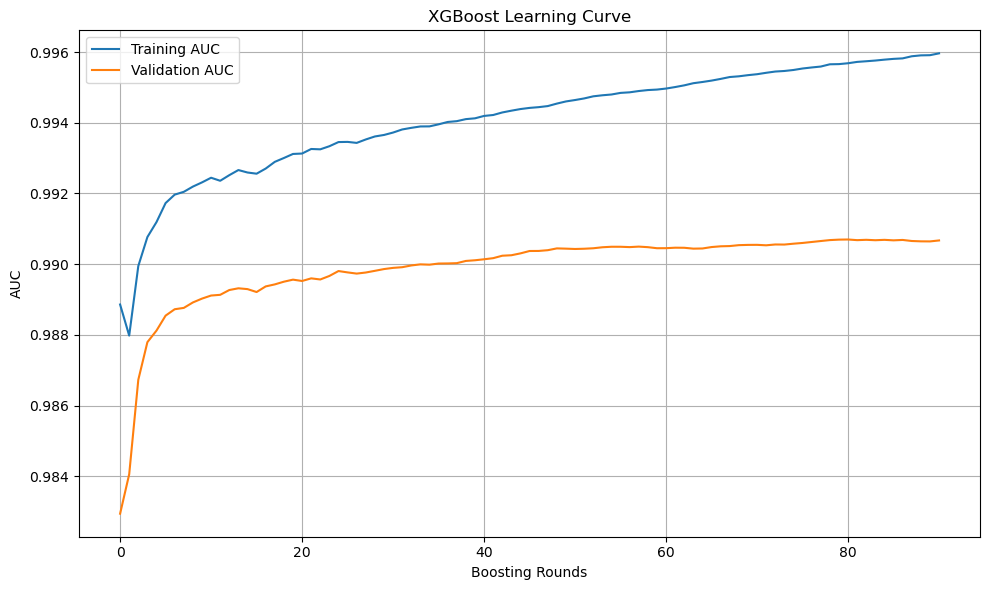

In [14]:
# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['auc'], label='Training AUC')
plt.plot(evals_result['validation']['auc'], label='Validation AUC')
plt.title('XGBoost Learning Curve')
plt.xlabel('Boosting Rounds')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('xgboost_learning_curve.png')
plt.show()

## 5. Evaluate the Model

Evaluating model...

--- Evaluation on Training Data ---
AUC-ROC:     0.9960
F1-Score:    0.9353
Precision:   0.9866
Recall:      0.8891
Confusion Matrix:
[[116015    279]
 [  2566  20563]]


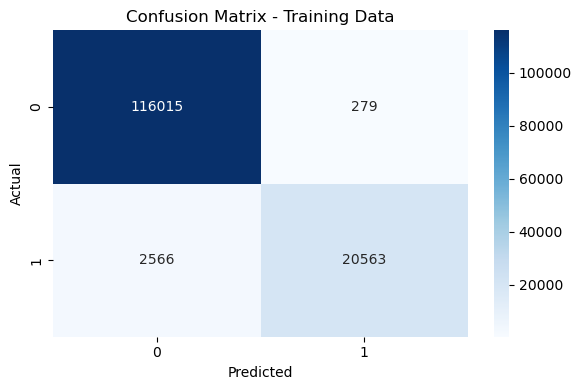


--- Evaluation on Validation Data ---
AUC-ROC:     0.9907
F1-Score:    0.9169
Precision:   0.9737
Recall:      0.8664
Confusion Matrix:
[[28943   135]
 [  772  5006]]


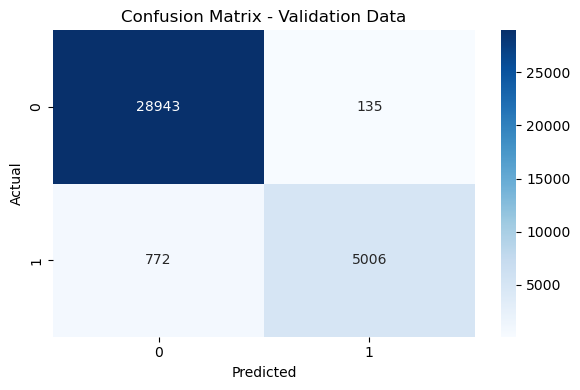

In [15]:
# === Step 4: Evaluate Model ===
def evaluate_model(model, X, y, dataset_name=""):
    dmatrix = xgb.DMatrix(X)
    y_prob = model.predict(dmatrix)
    y_pred = [1 if prob > 0.5 else 0 for prob in y_prob]
    
    # Compute metrics
    auc = roc_auc_score(y, y_prob)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)
    
    # Print results
    print(f"\n--- Evaluation on {dataset_name} ---")
    print(f"AUC-ROC:     {auc:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{dataset_name.lower().replace(" ", "_")}.png')
    plt.show()
    
    return auc, f1, precision, recall

# Evaluate on both datasets
print("Evaluating model...")
train_metrics = evaluate_model(final_model, X_train, y_train, "Training Data")
val_metrics = evaluate_model(final_model, X_val, y_val, "Validation Data")

<Figure size 1200x800 with 0 Axes>

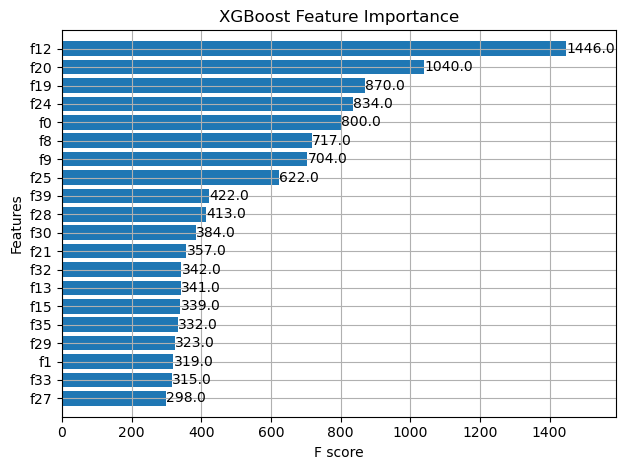


Top 10 Most Important Features:
   Feature   Importance
10     f11  1320.473389
11     f12    46.895218
16     f18    37.203213
35     f38    22.620064
12     f13    20.253853
25     f28    17.456738
1       f1    17.391630
9      f10    11.110274
20     f22     4.501915
30     f33     4.492587


In [16]:
# === Step 5: Feature Importance Analysis ===
# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(final_model, max_num_features=20, height=0.8)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png')
plt.show()

# Get feature names and importance values
feature_importance = final_model.get_score(importance_type='gain')
importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print top 10 important features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

In [17]:
# === Step 6: Compare with Baseline LSTM Model ===
print("\n=== Model Comparison Summary ===")
print(f"XGBoost Validation AUC: {val_metrics[0]:.4f}")
print(f"XGBoost Validation F1:  {val_metrics[1]:.4f}")
print("Note: Compare these metrics with your LSTM results")


=== Model Comparison Summary ===
XGBoost Validation AUC: 0.9907
XGBoost Validation F1:  0.9169
Note: Compare these metrics with your LSTM results
